<a href="https://colab.research.google.com/gist/shubajitsaha/f1ea0cb297492476e46ed0ec67719a0e/translitertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transliteration Baseline From English to Bengali
Authors: Shubajit Saha

[Reference Code](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

[Open in Colab](https://colab.research.google.com/github/Bangla-NLP/BLUE-Benchmark/blob/transliteration-base/src/transliteration/Translitertation.ipynb)


## Data Loading

In [0]:
import urllib.request
import json
%matplotlib inline

In [0]:
data_source_url = 'https://raw.githubusercontent.com/Bangla-NLP/BLUE-Benchmark/master/data/transliteration/transliteration_bn_en.txt'
filedata = urllib.request.urlretrieve(data_source_url)
filename = filedata[0]

In [75]:
data = []
with open(filename,'r') as fip:
    data += fip.read().splitlines()
print(len(data))

300


## Data Processing

1. Lower Case
2. Maximum Length of 25
3. Strip trailing white spaces

In [76]:
bengali_len_list = []
english_len_list = []
for line in data:
    jdata = json.loads(line)
    for word in jdata['words']:
        normalized_word = word['en'].strip()
        bengali_len_list.append(word['bn'])
        english_len_list.append(normalized_word)
print(len(bengali_len_list))
bengali_len_list = list(set(bengali_len_list))
english_len_list = list(set(english_len_list))
bengali_len_list = [len(word) for word in bengali_len_list]
english_len_list = [len(word) for word in english_len_list]
print('#Unique Bengali words: ',len(bengali_len_list))
print('#Unique English words: ',len(english_len_list))

4021
#Unique Bengali words:  3942
#Unique English words:  3908


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8e12c3eb8>]],
      dtype=object)

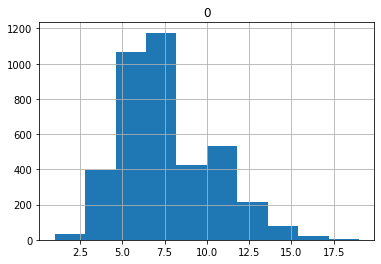

In [77]:
import pandas as pd

#Length distribution of bengali words
df = pd.DataFrame(bengali_len_list)
df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8924e29b0>]],
      dtype=object)

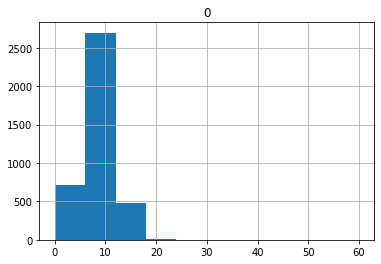

In [78]:
#Length distribution of bengali words
df = pd.DataFrame(english_len_list)
df.hist()

In [0]:
from collections import defaultdict
data_dict = defaultdict(list)
MAX_LEN = 25
for line in data:
    jdata = json.loads(line)
    for word in jdata['words']:
        normalized_word = word['en'].lower().strip()
        if len(normalized_word) <= MAX_LEN:
          data_dict[word['bn']].append(normalized_word)

#Remove duplicates
for k,v in data_dict.items():
    data_dict[k] = list(set(v))

In [80]:
total_judgements = 0
cnt = 0
for k,v in data_dict.items():
    total_judgements += len(v)
print("Unique Bengali words for which annotations present: ",len(data_dict))
print("Total annotations present (since one word might get multiple annotations due to sampling): ",total_judgements)
print("Annotation ratio: ",float(total_judgements)/len(data_dict))

Unique Bengali words for which annotations present:  3940
Total annotations present (since one word might get multiple annotations due to sampling):  3971
Annotation ratio:  1.0078680203045685


## Build Vocabulary

In [0]:
def build_vocabulary(l,threshold=0.0,start_token='<SOS>',end_token='<EOS>',unk_token='<UNK>'):
    vocab = defaultdict(int)
    for line in l:
        for ch in line:
            vocab[ch] += 1
    vocab_list = []
    for k,v in vocab.items():
        vocab_list.append((k,v))
    vocab_list = sorted(vocab_list,key=lambda x:-1*x[1])
    return [start_token] + [end_token] + [x[0] for x in vocab_list if x[1] >= threshold] + [unk_token]

In [82]:
bengali_vocab = build_vocabulary(data_dict.keys(),30)
n_bengali_vocab = len(bengali_vocab)
print(n_bengali_vocab)

60


In [83]:
english_words = []
for k in data_dict:
    english_words += data_dict[k]
english_vocab = build_vocabulary(english_words,10)
n_english_vocab = len(english_vocab)
print(n_english_vocab)

42


## Train-Validation Split

In [84]:
train_ratio = 0.9
n_train = int(len(data_dict)*train_ratio)
n_validation = len(data_dict) - n_train
print('#Train instances are: ',n_train)
print('#Validation instances are ',n_validation)

#Train instances are:  3546
#Validation instances are  394


In [0]:
def getDataSetFromKeys(key_list,data_dict):
    X = []
    y = []
    for key in key_list:
        for word in data_dict[key]:
            X.append(word)
            y.append(key)
    return X,y

In [86]:
import random

bn_words = list(data_dict.keys())
random.shuffle(bn_words)
bn_words_train = bn_words[:n_train]
bn_words_validation = bn_words[n_train:]

X_train,y_train = getDataSetFromKeys(bn_words_train,data_dict)
X_validation,y_validation = getDataSetFromKeys(bn_words_validation,data_dict)

print("Train Dataset size: ",len(X_train),len(y_train))
print("Validation Dataset size: ",len(X_validation),len(y_validation))
print(X_train[:10])
print(y_train[:10])

Train Dataset size:  3575 3575
Validation Dataset size:  396 396
['trinamuleo', 'sadharonoto', 'poton', 'hefajoter', 'noukatie', 'premikara', 'poreche', 'khelanoi', 'aborton', 'ashrer']
['তৃণমূলেও', 'সাধারণত', 'পতন৷', 'হেফাজতের', 'নৌকাটিই', 'প্রেমিকারা', 'প়ড়েছে', 'খেলানোই', 'আবর্তন', 'আসরের']


## Model Building

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
print("Pytorch Version: ",torch.__version__)
from IPython.core.debugger import set_trace

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Pytorch Version:  1.4.0
CUDA: False
cuda:0


## Tensor Utilities

In [0]:
def charToIndex(ch,vocab_list,unk_token='<UNK>'):
    try:
        return vocab_list.index(ch)
    except ValueError:
        return vocab_list.index(unk_token)

def wordToTensor(word,vocab_list,start_token='<SOS>',end_token='<EOS>',unk_token='<UNK>'):
    indices = [charToIndex(ch,vocab_list,unk_token) for ch in word] + [charToIndex(end_token,vocab_list)]
    tensor = torch.tensor(indices,dtype=torch.long)
    return tensor

def pairToTensor(source,source_vocab,target,target_vocab):
    return wordToTensor(source,source_vocab),wordToTensor(target,target_vocab)

In [89]:
print(wordToTensor('tomar',english_vocab))
print(wordToTensor('আমরা',bengali_vocab))

tensor([ 8,  3, 16,  2,  4,  1])
tensor([33, 13,  3,  2,  1])


## Training Utilities

In [0]:
import time
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.font_manager as mfm


data_source_url = 'https://www.omicronlab.com/download/fonts/Siyamrupali.ttf'
filedata = urllib.request.urlretrieve(data_source_url)
filename = filedata[0]
bengali_font = mfm.FontProperties(fname=filename)

In [0]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def trainInstance(
        input_tensor,
        target_tensor,
        encoder,
        decoder,
        encoder_optimizer,
        decoder_optimizer,
        criterion,
        target_start_token,
        target_end_token,
        teacher_forcing_ratio = 0.0,
        max_length=25):
    
    #print("input: ",input_tensor.size(),input_tensor)
    #print("target: ",target_tensor.size(),target_tensor)
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        #print("Encoder output: ",encoder_output.size())
        #print("Encoder hidden: ",encoder_hidden.size())
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[target_start_token]])

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        #print("Using teacher forching.")
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, torch.tensor([target_tensor[di]]))
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        #print("Not using teacher forching.")
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, torch.tensor([target_tensor[di]]))
            if decoder_input.item() == target_end_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
def trainInstanceWithAttention(
        input_tensor,
        target_tensor,
        encoder,
        decoder,
        encoder_optimizer,
        decoder_optimizer,
        criterion,
        target_start_token,
        target_end_token,
        teacher_forcing_ratio = 0.0,
        max_length=25):
    
    #print("input: ",input_tensor.size(),input_tensor)
    #print("target: ",target_tensor.size(),target_tensor)
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        #print("Encoder output: ",encoder_output.size())
        #print("Encoder hidden: ",encoder_hidden.size())
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[target_start_token]])

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        #print("Using teacher forching.")
        for di in range(target_length):
            decoder_output, decoder_hidden,decoder_attention = decoder(
                decoder_input, decoder_hidden,encoder_outputs)
            loss += criterion(decoder_output, torch.tensor([target_tensor[di]]))
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        #print("Not using teacher forching.")
        for di in range(target_length):
            decoder_output, decoder_hidden,decoder_attention = decoder(
                decoder_input, decoder_hidden,encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, torch.tensor([target_tensor[di]]))
            if decoder_input.item() == target_end_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
def train(encoder,
          decoder,
          n_iters,
          learning_rate,
          dropout,
          X,
          y,
          target_start_token,
          target_end_token,
          teacher_forcing_ratio,
          max_length,
          print_every=100,
          plot_every=100):
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    indices = [random.randint(0,len(X)-1) for _ in range(n_iters)]
    training_pairs = [(X[id],y[id])
                      for id in indices]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = trainInstance(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion,target_start_token,target_end_token,teacher_forcing_ratio,max_length)
        
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    return plot_losses

In [0]:
def trainWithAttention(encoder,
          decoder,
          n_iters,
          learning_rate,
          dropout,
          X,
          y,
          target_start_token,
          target_end_token,
          teacher_forcing_ratio,
          max_length,
          print_every=100,
          plot_every=100):
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    indices = [random.randint(0,len(X)-1) for _ in range(n_iters)]
    training_pairs = [(X[id],y[id])
                      for id in indices]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = trainInstanceWithAttention(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion,target_start_token,target_end_token,teacher_forcing_ratio,max_length)
        
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    return plot_losses

In [0]:
def evaluateInstance(source,encoder,decoder,start_token, end_token, source_vocab, target_vocab,max_length=25):
    with torch.no_grad():
        input_tensor = wordToTensor(source,source_vocab)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
        #print(encoder_hidden)
        decoder_input = torch.tensor([[start_token]])  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            #print(decoder_output.size(),decoder_hidden.size())
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == end_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(target_vocab[topi.item()])
                
            decoder_input = topi.squeeze().detach()
            
        return decoded_words

In [0]:
def evaluateInstanceWithAttention(source,encoder,decoder,start_token, end_token, source_vocab, target_vocab,max_length=25):
    with torch.no_grad():
        input_tensor = wordToTensor(source,source_vocab)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        print(source,input_tensor,input_length)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size)
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        #print(encoder_hidden)
        print("start token: ",start_token,"end_token: ",end_token)
        decoder_input = torch.tensor([[start_token]])  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden,decoder_attention = decoder(
                decoder_input, decoder_hidden,encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            #print(decoder_output.size(),decoder_hidden.size())
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == end_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(target_vocab[topi.item()])
                
            decoder_input = topi.squeeze().detach()
            
        return decoded_words,decoder_attentions[:di+1]

In [0]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words,fontproperties=bengali_font)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

## Model

### Encode-Decoder with GRU

In [0]:
class Encoder(nn.Module):
    def __init__(self,input_size,hidden_size):
        super(Encoder,self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size,hidden_size)
        self.gru = nn.GRU(hidden_size,hidden_size)
        
    def forward(self,input,hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output = embedded
        output,hidden = self.gru(output,hidden)
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size)

In [0]:
class Decoder(nn.Module):
    def __init__(self,output_size,hidden_size):
        super(Decoder,self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size,hidden_size)
        self.gru = nn.GRU(hidden_size,hidden_size)
        self.out = nn.Linear(hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,input,hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output = F.relu(embedded)
        output,hidden = self.gru(output,hidden)
        output = self.softmax(self.out(output[0]))
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size)

In [0]:
class AttnDecoderRNN(nn.Module):
  def __init__(self,output_size, hidden_size, max_length, dropout_p=0.1):
      super(AttnDecoderRNN, self).__init__()
      self.hidden_size = hidden_size
      self.output_size = output_size
      self.dropout_p = dropout_p
      self.max_length = max_length

      self.embedding = nn.Embedding(self.output_size, self.hidden_size)
      self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
      self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
      self.dropout = nn.Dropout(self.dropout_p)
      self.gru = nn.GRU(self.hidden_size, self.hidden_size)
      self.out = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hidden, encoder_outputs):
      embedded = self.embedding(input).view(1, 1, -1)
      embedded = self.dropout(embedded)

      attn_weights = F.softmax(
          self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
      attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))

      output = torch.cat((embedded[0], attn_applied[0]), 1)
      output = self.attn_combine(output).unsqueeze(0)

      output = F.relu(output)
      output, hidden = self.gru(output, hidden)

      output = F.log_softmax(self.out(output[0]), dim=1)
      return output, hidden, attn_weights

  def initHidden(self):
      return torch.zeros(1, 1, self.hidden_size, device=device)

### Experiment-1
### Details: 
Model: Encoder Decoder
Architecture: Single layer GRU 128 dimension

In [0]:
# ## Parameters:
# learning_rate = 5*1e-2
# n_iters = 5000
# dropout = 0.5
# teacher_forcing_ratio = 0.0
# max_length = 25
# input_dim = n_english_vocab
# output_dim = n_bengali_vocab
# hidden_dim = 256
# encoder = Encoder(input_dim,hidden_dim)
# decoder = Decoder(output_dim,hidden_dim)

In [0]:
# ## Training English to Bengali Transliteration
# X_train_tensor = [wordToTensor(word,english_vocab) for word in  X_train]
# y_train_tensor = [wordToTensor(word,bengali_vocab) for word in  y_train]
# plot_losses = train(encoder,decoder,n_iters,learning_rate,dropout,X_train_tensor,y_train_tensor,bengali_vocab.index('<SOS>'),bengali_vocab.index('<EOS>'),teacher_forcing_ratio,max_length)
# showPlot(plot_losses)

### Experiment-2
### Details: 
Model: Encoder Decoder With Attentio
Architecture: Single layer GRU 128 dimension with Attention

In [1]:
## Parameters:
learning_rate = 5*1e-2
n_iters = 5000
n_epochs = 5
dropout = 0.5
teacher_forcing_ratio = 0.0
max_length = 25
input_dim = n_english_vocab
output_dim = n_bengali_vocab
hidden_dim = 256
encoder = Encoder(input_dim,hidden_dim)
decoder = AttnDecoderRNN(output_dim,hidden_dim,max_length)

NameError: ignored

0m 8s (- 7m 8s) (100 2%) 3.0322
0m 16s (- 6m 45s) (200 4%) 2.8785
0m 24s (- 6m 28s) (300 6%) 2.6111
0m 32s (- 6m 12s) (400 8%) 2.3205
0m 39s (- 5m 57s) (500 10%) 2.2465
0m 46s (- 5m 41s) (600 12%) 1.9508
0m 53s (- 5m 28s) (700 14%) 1.9703
1m 0s (- 5m 16s) (800 16%) 2.0544
1m 7s (- 5m 8s) (900 18%) 2.3089
1m 15s (- 5m 2s) (1000 20%) 2.4390
1m 23s (- 4m 55s) (1100 22%) 2.9319
1m 31s (- 4m 48s) (1200 24%) 2.8570
1m 39s (- 4m 43s) (1300 26%) 2.9299
1m 48s (- 4m 37s) (1400 28%) 3.1346
1m 57s (- 4m 33s) (1500 30%) 3.2769
2m 5s (- 4m 27s) (1600 32%) 3.4071
2m 14s (- 4m 21s) (1700 34%) 3.3530
2m 23s (- 4m 15s) (1800 36%) 3.1634
2m 33s (- 4m 10s) (1900 38%) 3.3156
2m 42s (- 4m 3s) (2000 40%) 3.1805
2m 52s (- 3m 57s) (2100 42%) 3.2915
3m 0s (- 3m 50s) (2200 44%) 3.2537
3m 10s (- 3m 43s) (2300 46%) 3.1108
3m 19s (- 3m 36s) (2400 48%) 3.2390
3m 29s (- 3m 29s) (2500 50%) 3.1508
3m 39s (- 3m 22s) (2600 52%) 3.2287
3m 49s (- 3m 15s) (2700 54%) 3.1480
3m 58s (- 3m 7s) (2800 56%) 2.9987
4m 8s (- 2m 59s

<Figure size 432x288 with 0 Axes>

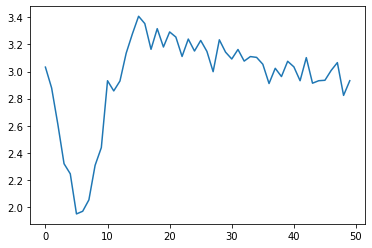

In [193]:
## Training English to Bengali Transliteration
X_train_tensor = [wordToTensor(word,english_vocab) for word in  X_train]
y_train_tensor = [wordToTensor(word,bengali_vocab) for word in  y_train]
#print(X_train[:10],y_train[:10])
plot_losses = trainWithAttention(encoder,decoder,n_iters,learning_rate,dropout,X_train_tensor,y_train_tensor,bengali_vocab.index('<SOS>'),bengali_vocab.index('<EOS>'),teacher_forcing_ratio,max_length)
showPlot(plot_losses)

267
aimar tensor([ 2,  6, 16,  2,  4,  1]) 6
start token:  0 end_token:  1
Source:  aimar
Predicted:  াাাাাাা<EOS>
Gold:  আইমার


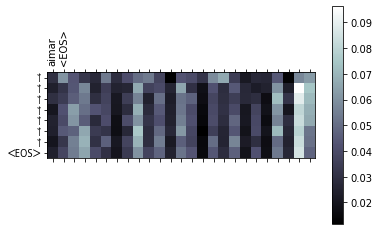

In [195]:
id = random.randint(0,len(X_validation)-1)
print(id)
# def evaluateInstanceWithAttention(
#     source,
#     encoder,
#     decoder,
#     start_token, 
#     end_token,
#     source_vocab,
#     target_vocab,
#     max_length=25)
input_sentence = X_validation[id]
gold = y_validation[id]
output_words, attentions = evaluateInstanceWithAttention(
    input_sentence,
    encoder,
    decoder,
    bengali_vocab.index('<SOS>'),
    bengali_vocab.index('<EOS>'),
    english_vocab,
    bengali_vocab,
    max_length)
print("Source: ",input_sentence)
print("Predicted: ",''.join(output_words))
print("Gold: ",gold)
showAttention(input_sentence, output_words, attentions)